# Text Processing - Exercises

In [332]:
import requests
import json
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import sys
import os
import re
import string
import operator
import math
from wordcloud import WordCloud
import networkx as nx
import community

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
plt.style.use('seaborn-deep')

def sortDict(d: set) -> set:
    return sorted(d.items(), key=operator.itemgetter(1), reverse=True)

## Exercise 1

### 3.12.6

- `[a-zA-Z]+` matches every word with at least one letter, both lower- and uppercase.
- `[A-Z][a-z]*` matches every word that starts with an uppercase character, followed by zero or more lowercase characters
- `p[aeiou]{,2}t` matches words starting with a 'p' followed by any vocal, at most two times, and with a 't' at the end.
- `\d+(\.\d+)?` matches words starting with at least one digit, which might be followed by a decimal point and one or more digits (floating numbers)
- `([^aeiou][aeiou][^aeiou])*` matches every word starting with a consonant (not `[aeiou]`) followed by a vocal, followed by a consonant. This is repeated zero or more times.
- `\w+|[^\w\s]+` matches any alphanumeric character repeated zero or more times, or words that is not alphanumeric or have whitespaces, with zero or more characters.

### 3.12.30

In [3]:
response = requests.get('https://www.gutenberg.org/files/2554/2554-0.txt')
text = response.text

In [4]:
porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()

porter_text = list(map(porter.stem, text.split(' ')))
lancaster_text = list(map(lancaster.stem, text.split(' ')))

In [5]:
print(porter_text[:10])
print(lancaster_text[:10])

['\ufeffthe', 'project', 'gutenberg', 'ebook', 'of', 'crime', 'and', 'punishment,', 'by', 'fyodor']
['\ufeffthe', 'project', 'gutenberg', 'ebook', 'of', 'crim', 'and', 'punishment,', 'by', 'fyod']


## Exercise 2 - TF-IDF and the Republican and Democratic parties

### TF-IDF

Stands for **term fequency - inverse document ferquenc**. 
It is a statistic that tries to measure how important words are to a document.

In [306]:
congress = 115
filename = os.path.join('../data', 'H' + str(115) + '.csv')
df = pd.read_csv(filename)
    
names = list(df['WikiPageName'])
clean_names = set([x for name in names for x in name.split('_')])
names_parties = [(row['WikiPageName'], row['Party']) for _, row in df.iterrows()]

In [7]:
endpoint = 'https://en.wikipedia.org/w/api.php'

def getWiki(query: str):
    action = 'action=query'
    title = 'titles=%s' % query
    content = 'prop=extracts&exlimit=max&explaintext'
    dataformat = 'format=json'
    
    url = endpoint + '?' + '&'.join([
        action, title, content, dataformat
    ])
    
    return requests.get(url)

In [8]:
def getText(response):
    pages = response.json()['query']['pages']
    if '-1' in pages:
        return ''
    else:
        return str(bytes(list(pages.values())[0]['extract'], 'utf8'))

In [9]:
republican = []
democratic = []
for name, party in tqdm(names_parties):
    response = getWiki(name)
    if response.status_code == 200:
        if party == 'Democratic': 
            democratic.append(getText(response))
        else: 
            republican.append(getText(response))

In [10]:
text_republican = '\n'.join(republican)
text_democratic = '\n'.join(democratic)

with open('./data/republican.txt', 'w') as filename:
    filename.write(text_republican)
    
with open('./data/democratic.txt', 'w') as filename:
    filename.write(text_democratic)

#### Cleaning the text

In [11]:
def removePunctuation(text: str):
    return text.translate(str.maketrans('', '', string.punctuation))

tokens = nltk.word_tokenize(removePunctuation(text.lower()))
tokens = [token for token in tokens if token not in name]

In [95]:
def tokenize(text: str):
    sw = stopwords.words('english')
    
    text = removePunctuation(text.lower())
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens 
                  if token not in clean_names
                  and token not in sw
                  and not token.isdigit()
         ]
    return tokens

In [96]:
tokens_democratic = tokenize(text_democratic)
tokens_republican = tokenize(text_republican)

Finding the term frequency for each token

In [97]:
freq_democratic = FreqDist(tokens_democratic)
freq_republican = FreqDist(tokens_republican)

In [98]:
freq_democratic_sorted = sorted(freq_democratic.items(), key=operator.itemgetter(1), reverse=True)
freq_republican_sorted = sorted(freq_republican.items(), key=operator.itemgetter(1), reverse=True)

In [99]:
print(freq_democratic_sorted[:5])
print(freq_republican_sorted[:5])

[('house', 1993), ('district', 1562), ('democratic', 1426), ('us', 1353), ('election', 1249)]
[('house', 2660), ('republican', 2231), ('us', 1813), ('would', 1780), ('district', 1644)]


In both cases, house is the number one in the frequency list. They also both have their own parties, as well as US.
These three are logical that they would be on the wikipedia page for each of the politicians multiple times, as the sites contain all the factual information about what the politicians have done. 
We also note that election is high on the democratic party list.

#### Calculating IDF

In [100]:
N_democratic = len([x for x in democratic if not x == '']) 
N_republican = len([x for x in republican if not x == ''])

In [101]:
document_sets_democratic = [set(tokenize(text)) for text in democratic]
document_sets_republican = [set(tokenize(text)) for text in republican]

In [102]:
def calculate_n_ts(tokens: list, documents: list) -> set:
    return {
        word: len([None for document in documents if word in document])
           for word in set(tokens)
    }

In [103]:
n_ts_democratic = calculate_n_ts(tokens_democratic, document_sets_democratic)
n_ts_republican = calculate_n_ts(tokens_republican, document_sets_republican)

In [104]:
def calculateIDF(nts: set, N: int) -> set:
    base = 2
    return { word: math.log(N / n_t, base)
        for word, n_t in nts.items()        
    }

In [105]:
IDF_republican = calculateIDF(n_ts_republican, N_republican)
IDF_democratic = calculateIDF(n_ts_democratic, N_democratic)

In [113]:
print(sortDict(IDF_republican)[:5])
print(sortDict(IDF_democratic)[:5])

[('solidarity', 7.894817763307945), ('uravan', 7.894817763307945), ('fractionated', 7.894817763307945), ('metras', 7.894817763307945), ('59xe2x80x9336', 7.894817763307945)]
[('servicerahall', 7.599912842187128), ('nnalan', 7.599912842187128), ('omar', 7.599912842187128), ('ktlatv', 7.599912842187128), ('trilliondollar', 7.599912842187128)]


The base of the logarithm used does not really matter, as it only detemines the range of the output. 
For such a small number of documents as we have here, the smaller base is better.
With a much higher number of documents, a larger base would most likely be better.

#### Calculating TF-IDF

In [107]:
def calculateTF_IDF(tfs: set, IDFs: set) -> set:
    return {
        word: tf * IDFs[word]
        for word, tf in tfs.items()
    }

In [108]:
TF_IDF_republican = calculateTF_IDF(freq_republican, IDF_republican)
TF_IDF_democratic = calculateTF_IDF(freq_democratic, IDF_democratic)

In [109]:
print(sortDict(TF_IDF_democratic)[:10])
print(sortDict(TF_IDF_republican)[:10])

[('rangel', 1108.5789949670977), ('maloney', 830.0631471223041), ('ellison', 704.50601425904), ('cohen', 680.8600324016697), ('cicilline', 577.5933760062217), ('california', 577.4398297099949), ('moran', 570.0223527083747), ('sinema', 562.3935503218474), ('lewis', 561.586403381192), ('gabbard', 505.2558286831416)]
[('bachmann', 858.2250089367697), ('sanford', 750.8727762478277), ('capito', 726.3232342243309), ('king', 707.72962475447), ('rohrabacher', 677.9040427804135), ('schock', 618.3658157335052), ('fleming', 613.638780934407), ('cotton', 605.7461052083316), ('brooks', 602.0625848868771), ('collins', 599.0485465630961)]


The words are not that much more descriptive of the parties. 
We still see a lot of names, along with some of the larger states that are heavely leaning towards one of the parties.

TF-IDF does not tell anything about specific documents, but about the words in all the documents.

## Exercise 3 - Word Cloud

In [118]:
clean_text_republican = ' '.join(tokens_republican)
clean_text_democratic = ' '.join(tokens_democratic)

In [124]:
def drawWordCloud(text: str):
    wordcloud = WordCloud().generate(text)
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.imshow(wordcloud)
    ax.axis('off')
    plt.show()

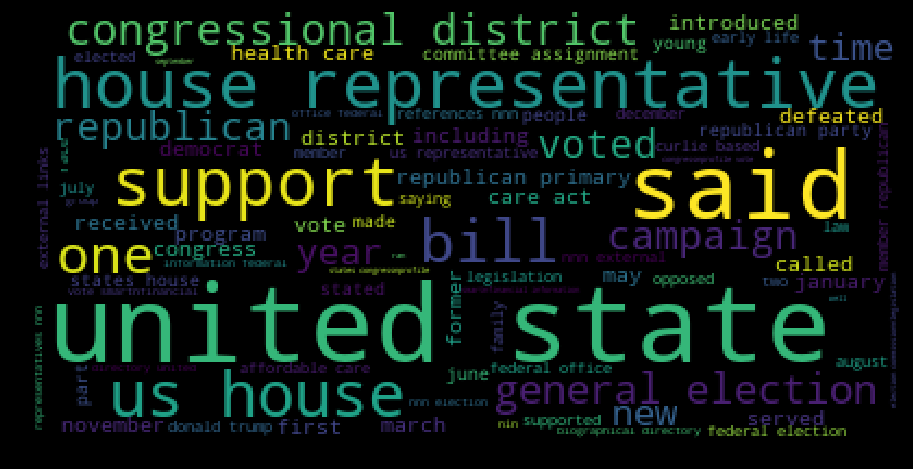

In [125]:
drawWordCloud(clean_text_republican)

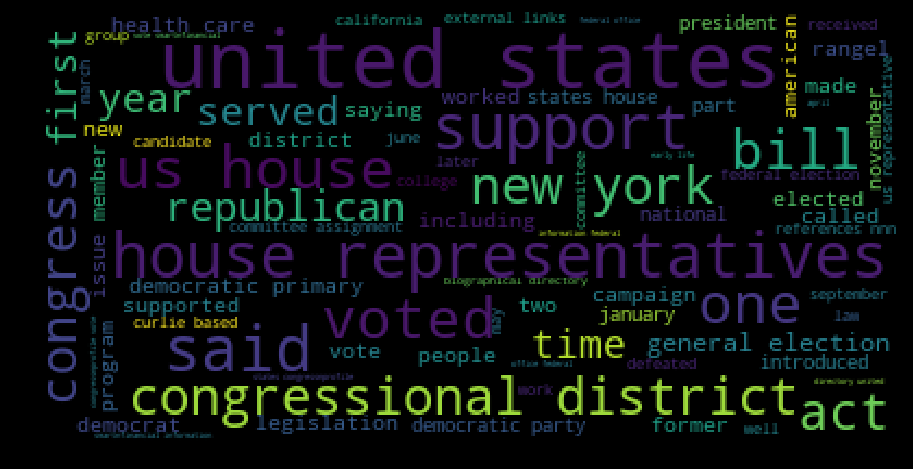

In [126]:
drawWordCloud(clean_text_democratic)

Many of the same words occure on both images.
Again we see popular states for each of the parties appear. 

## Exercise 4 - Community detection

**Modularity** is in general how much you are able to split up a system into separate components, each of which is still able to operate.  
In the graph, a community is a subgraph that is more connected than you would expect, compared to how the rest of the graph is connected.

In [246]:
# %load ../congress_network.py
import os, json, re
from pandas import DataFrame

def getFileContent(name: str, congress_number: int) -> str:
    '''Reading the file content for a congress member

    @param name: Name of the congress member
    @param congress_number: The number of congress to look in
    '''
    with open(os.path.join('..\\data', str(congress_number), str(name)), 'r') as f:
        content = json.load(f)

    return content['revisions'][0]['*']

def isCongressMember(name: str, members) -> bool:
    '''Check in the name is a congress member

    @param name: Name of a potential congress member
    @param members: Known members of the congress
    '''
    name = re.sub(r'\ ', '_', name)
    return name in members

def findLinks(content: str) -> list:
    '''Find links in a text

    @param content: The text to search for links in
    '''
    for link in re.findall(r'\[\[(.*?)\]\]', content):
        yield re.sub(r'\|.*', '', link)

def getCongressConnections(name: str, congress_number: int, members) -> list:
    '''Get all the connections for a given congress member

    @param name: Name of the congress member
    @param congress_number: The number of the congress to look at
    '''
    content = getFileContent(re.sub('_', ' ', name), congress_number)
    links = findLinks(content)
    for x in links:
        if isCongressMember(x, members):
            yield x

def getEdges(congress_number: int, members: list) -> list:
    '''Get all the edges in a given congress

    @param congress_number: The number of the congress to get the edges for
    '''
    for member in members:
        cleaned_member = re.sub(r'_', ' ', member)
        for connection in getCongressConnections(member, congress_number, members):
            yield cleaned_member, connection

def getNodes(congress_number: int, members: list, df: DataFrame) -> list:
    '''Get all the nodes for a given congress with their state and party as attribute

    @param congress_number: The number of the congress
    '''
    for member in members:
        row = df.loc[df['WikiPageName'] == member].reset_index()

        party = str(row.at[0, 'Party'])
        if party == 'Republican': color ='red'
        else: color = 'blue'
        attributes = {
            'state': row.at[0, 'State'],
            'party': party,
            'node_color': color
        }
        member = re.sub(r'_', ' ', member)

        yield (member, attributes)

def getMembers(df: DataFrame) -> list:
    '''Get all the members from a given congress stored as pandas
    '''
    return df.groupby('WikiPageName')['WikiPageName'].groups

### Creating network

In [248]:
members = getMembers(df)
connections = list(getEdges(congress, members))
nodes = list(getNodes(congress, members, df))

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(connections)

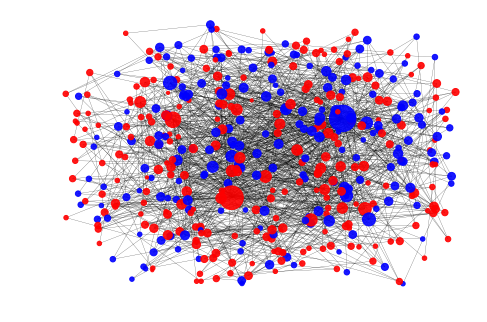

In [249]:
options = {
    'width': 0.2,
    'alpha': 0.9,
}

node_color = [attr['node_color'] for _, attr in nodes]
node_size = [G.degree(n) * 10 for n, _ in nodes]
pos = nx.spring_layout(G, k=0.15, iterations=2)
nx.draw(G, pos, node_size=node_size, node_color=node_color, **options)

In [326]:
# %load modularity.py
from networkx import Graph

def nodesWithGivenAttribute(G: Graph, attribute: str, value: str) -> dict:
    '''Find all the nodes from a given party

    @param G: networkx graph to look in
    @param attribute: used to group the nodes
    @param value: to filter all the nodes with
    @returns: A dictionary of nodes with their attributes
    '''
    return { x: G.node[x] for x in G.nodes() if G.node[x][attribute] == value }

def totalDegree(G: Graph, nodes: dict) -> int:
    '''Calculates the sum of all the degrees of the nodes

    @returns: The total degree of all the nodes
    '''
    return sum([G.degree(x) for x in nodes.keys()])

def totalNumberOfLinksWithinCommunity(G: Graph, nodes: dict) -> int:
    '''Find the total number of links within a community

    @param G: networkx graph to look in
    @param attribute: to group the community
    @param nodes: The community of nodes
    @returns: The number of links within a community
    '''
    return len([other
        for node in nodes
            for other in G.neighbors(node)
                if other in nodes
    ]) / 2

def modularityStats(G: Graph, nodes: dict) -> (float, float, float):
    '''Get the relevant constants for calculating modularity stats

    @param G: networkx graph to look in
    @param attribute: used to group the community
    @param party: to define the community

    @returns: (k_c, L_c, L)
    '''
    return (
        totalDegree(G, nodes)
        , totalNumberOfLinksWithinCommunity(G, nodes)
        , len(G.edges())
    )

def modularity(G: Graph, nodes: dict) -> float:
    '''Calculate the modularity of a community of nodes given the party

    @param G: networkx graph to look in
    @param party: The party that defines the community
    @returns: The modularity of the nodes in the graph with the given party
    '''
    k_c, L_c, L = modularityStats(G, nodes)

    M_c = L_c / L - (k_c / (2 * L))**2

    return M_c

In [328]:
nodes_democratic = nodesWithGivenAttribute(G, 'party', 'Democratic')
nodes_republican = nodesWithGivenAttribute(G, 'party', 'Republican')

print('Modulartiy for Democratic: {0:.5f}'.format(modularity(G, nodes_democratic)))
print('Modularity for Republican: {0:.5f}'.format(modularity(G, nodes_republican)))
print('The total modularity for the congress graph is: {0:.5f}'
      .format(modularity(G, nodes_democratic) + modularity(G, nodes_republican)))

Modulartiy for Democratic: 0.07275
Modularity for Republican: 0.07319
The total modularity for the congress graph is: 0.14594


We can also look at the modularity based on the different states as well.

In [329]:
modularity_states = [(state, modularity(G, nodesWithGivenAttribute(G, 'state', state)))
                     for state in df.groupby('State')['State'].groups]

In [330]:
print('Modularity based on states: {0:.5f}'.format(sum([x for _, x in modularity_states])))
for state, m in modularity_states[:5]:
    print('Modularity for {0:<16s} {1:>10.5f}'.format(state, m))

Modularity based on states: 0.16358
Modularity for Alabama             0.00332
Modularity for Alaska             -0.00001
Modularity for Arizona             0.00223
Modularity for Arkansas           -0.00002
Modularity for California          0.03565


Is it can be seen, the total modularity of the graph when the communities are based on the states are slightly better than when they are based on the parties.
The matches will with what we have found earlier, where most politicans are connected with people from their own state.

## Exercise 9 - Community detection on the house of representatives network

In [338]:
partition = community.best_partition(G)
louvain_modularities = {}
for c in set(partition.values()):
    nodes = { node: {} for node in partition.keys() if partition[node] == c }
    louvain_modularities[c] = modularity(G, nodes)

In [342]:
print('Modularity given by the Louvain partition: {0:.5f}'
      .format(sum([m for _, m in louvain_modularities.items()])))
for c, m in louvain_modularities.items():
    print('Community {0:>2d} modularity: {1:.5f}'.format(c, m))

Modularity given by the Louvain partition: 0.46797
Community  0 modularity: 0.04065
Community  1 modularity: 0.02477
Community  2 modularity: 0.07577
Community  3 modularity: 0.03147
Community  4 modularity: 0.05553
Community  5 modularity: 0.03015
Community  6 modularity: 0.02121
Community  7 modularity: 0.08510
Community  8 modularity: 0.01261
Community  9 modularity: 0.03307
Community 10 modularity: 0.02628
Community 11 modularity: 0.00687
Community 12 modularity: 0.02449
